# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/home/ahmad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    #for row in open(file_name, encoding='utf8'):
    for row in open(file_name):
        if cnt < num_samples :
            #print(row)
            sents = row.split("\t")
            input_text = sents[0]
            
            target_text = '\t' + sents[1] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[1])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1
    # Add special tokens to vocab_to_int
    codes = ['\t','\n']
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1
    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t, vocab_to_int[char]] = 1.
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, vocab_to_int[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, vocab_to_int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [12]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    # TODO: Add Embedding for chars
    #encoder = LSTM(latent_dim, return_state=True) #LSTM
    encoder = Bidirectional(LSTM(latent_dim, return_state=True)) # Bi LSTM
    #encoder = Bidirectional(GRU(latent_dim, return_state=True))# Bi GRU
    #encoder = GRU(latent_dim, return_state=True)# GRU

    #encoder_outputs, state_h, state_c = encoder(encoder_inputs)# LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs)# Bi LSTM
    #encoder_outputs, state_f, state_b = encoder(encoder_inputs)# Bi GRU

    #state = Concatenate()([state_f, state_b])# Bi GRU
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #encoder_states = [state]# Bi GRU
    #encoder_states = [state_f_h, state_f_c, state_b_h, state_b_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    #decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)# LSTM
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    #decoder_lstm = GRU(latent_dim*2, return_sequences=True, return_state=True)# Bi GRU
    '''
    decoder_outputs, _, _ = Bidirectional(decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states))
    '''

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)


    #decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    encoder_model = Model(encoder_inputs, encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    #decoder_states = [state] # Bi GRU
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Load data

In [13]:
data_path = '../../dat/'

In [14]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [15]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [16]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [17]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

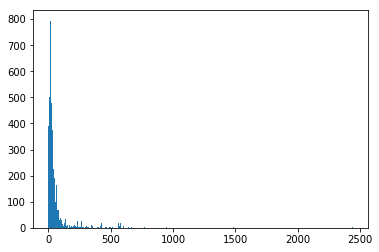

In [18]:
h = plt.hist(lengths, bins=500)

In [19]:
h[0]

array([392., 500., 700., 794., 734., 478., 374., 326., 226., 226., 192.,
        98.,  86., 166.,  80.,  68.,  70.,  40.,  28.,  58.,  36.,  28.,
        10.,  14.,   8.,  16.,  18.,  26.,  34.,   8.,  44.,  10.,  12.,
         0.,  12.,  22.,   2.,   2.,   6.,   4.,   8.,   8.,   2.,  10.,
         8.,   2.,   2.,  26.,   8.,   4.,   0.,   4.,   2.,   2.,  26.,
         2.,   2.,   2.,   2.,   0.,   8.,   4.,   6.,   4.,   4.,   0.,
         4.,   0.,   0.,   0.,  10.,   4.,   6.,   8.,   0.,   0.,   0.,
         0.,   2.,   0.,   2.,   0.,   2.,   0.,   0.,   6.,   6.,  18.,
         0.,   0.,   0.,   0.,   0.,   2.,   0.,   2.,   2.,   0.,   0.,
         2.,   2.,   4.,   2.,   0.,  26.,   2.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  18.,   6.,   0.,  20.,   0.,   0.,
         0.,   0.,   6.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
         0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [20]:
h[1]

array([   0.  ,    4.88,    9.76,   14.64,   19.52,   24.4 ,   29.28,
         34.16,   39.04,   43.92,   48.8 ,   53.68,   58.56,   63.44,
         68.32,   73.2 ,   78.08,   82.96,   87.84,   92.72,   97.6 ,
        102.48,  107.36,  112.24,  117.12,  122.  ,  126.88,  131.76,
        136.64,  141.52,  146.4 ,  151.28,  156.16,  161.04,  165.92,
        170.8 ,  175.68,  180.56,  185.44,  190.32,  195.2 ,  200.08,
        204.96,  209.84,  214.72,  219.6 ,  224.48,  229.36,  234.24,
        239.12,  244.  ,  248.88,  253.76,  258.64,  263.52,  268.4 ,
        273.28,  278.16,  283.04,  287.92,  292.8 ,  297.68,  302.56,
        307.44,  312.32,  317.2 ,  322.08,  326.96,  331.84,  336.72,
        341.6 ,  346.48,  351.36,  356.24,  361.12,  366.  ,  370.88,
        375.76,  380.64,  385.52,  390.4 ,  395.28,  400.16,  405.04,
        409.92,  414.8 ,  419.68,  424.56,  429.44,  434.32,  439.2 ,
        444.08,  448.96,  453.84,  458.72,  463.6 ,  468.48,  473.36,
        478.24,  483

In [21]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  14.64
Count of most probable lenght =  794.0
Min length =  4.88


In [22]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [23]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [24]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [25]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [26]:
len(input_texts)

2135

# Results of pre-training on generic data

In [27]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [28]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [29]:
num_samples = 1000
tess_correction_data = os.path.join(data_path, 'all_ocr_data.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [30]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [31]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [32]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [33]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [34]:
# TODO

In [35]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

3135
Claim Type:V BA ccient - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


oPlicyhodler/wre fnormation 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Last Name: 
 	Last Name:


Social Security Numbrez: 
 	Social Security Number:


Bitrh Date: 
 	Birth Date:


Gender: 
 	Gender:


Language iPrefrence: 
 	Language Preference:


Addressc Line :1 
 	Address Line 1:


Cpity: 
 	City:




## Build vocab

In [36]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [37]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [38]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3135
Number of unique input tokens: 106
Number of unique output tokens: 106
Max sequence length for inputs: 49
Max sequence length for outputs: 49


# Prepare training data

## Train/test split

In [39]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [40]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Test data

In [41]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [42]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [43]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 106)    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 743424      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 106)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3

# Training

In [44]:
batch_size = 64  # Batch size for training.
epochs = 1  
lr = 0.01

# Learning rate decay

In [45]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [47]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [48]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [49]:
#callbacks_list.append(lrate)

In [50]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 2664 samples, validate on 471 samples
Epoch 1/1
2664/2664 [==============================] - 77s 29ms/step - loss: 1.7364 - categorical_accuracy: 0.0656 - val_loss: 1.4572 - val_categorical_accuracy: 0.0996

Epoch 00001: val_categorical_accuracy improved from -inf to 0.09957, saving model to best_model.hdf5


/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [51]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [52]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Citly Stte Zip
GT sentence: City State Zip

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Payment by Visa[ or MasterCard[ ]
GT sentence: Payment by Visa [ ] or Mastercard [ ]

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Cty: Sylvana
GT sentence: City: Sylvania

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: C. Signature of Attending Physician 
GT sentence: C. Signature of Attending Physician

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: C. Signaturoe of Attendingh Physician
GT sentence: C. Signature of Attending Physician

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Spouse On & Off—Job Aoc May 1, 2015 
GT sentence: Spouse On & Off-Job Acc May 1, 2015

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Acct #: 
GT sentence: Acct #:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: IFRST M

-
Input sentence: Employer Nana;
GT sentence: Employer Name:

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: STATEMENT OF SERVICES 
GT sentence: STATEMENT OF SERVICES

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Iensurebd Social Secuty umber
GT sentence: Insured Social Security Number

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: ?3630! 0 
GT sentence: 73630/ ?

Decoded sentence: 03/1118

-
Input sentence: Merchant ID: 
GT sentence: Merchant ID: 

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Friday: No
GT sentence: Friday: No

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: INSURED/ATIENT STATEMEjN T(PLEAES PIN)T
GT sentence: INSURED/PATIENT STATEMENT (PLEASE PRINT)

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Hospital N anle: Medlixpress 
GT sentence: Hospital Name: MedExpress

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: c Account ii: 
GT sentence: Account #:

Decoded sentence: Pati e  

In [53]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [54]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: StatefProvince : 
GT sentence: State/Province:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Insured Coverage Tpel Coverage Efecthive Dat

GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: City:
GT sentence: City:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Edgewood
GT sentence: EDGEWOOD

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Total Monthlyr Premium: $40.47 
GT sentence: Total Monthly Premium: $40.47

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Allowed Amnum:
GT sentence: Allowed Amount: $ 136.22

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Confirmation of oCvrage
GT sentence: Confirmation of Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: PIC) Payori'ﬁlan 
GT sentence: F/O Payor/Plan

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Surg 91'3'lnf01'Iilation No
GT sentence: Surgery Informati

-
Input sentence: Toatcl Monthly Premuim 3$m1.81
GT sentence: Total Monthly Premium: $31.81

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: If yes, on what date (mm/dd/yy)?
GT sentence: If yes, on what date (mm/dd/yy)?

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Sales Tax: 0.00 
GT sentence: Sales Tax: 0.00

Decoded sentence: Pate  e  er  e  er  e 

-
Input sentence: Claim Tji'pe: V'B Accident - Accidental Injury 
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Surglml Pmnedure 
GT sentence: Surgical Procedure 

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Oiignla Print Dat:e
GT sentence: Original Print Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Medical Provider Ianformation - Physliciano
GT sentence: Medical Provider Information - P

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: EE Name: 
GT sentence: EE Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: El)ll)lﬂ_\‘l]l ent Information 
GT sentence: Employment Information

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: ﬂvuzs Per Week: 30.00 
GT sentence: Hours Per Week: 30.00

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Proivder Firs tNam:e Jafsminder
GT sentence: Provider First Name: Jasminder

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Electronicalyl Sigend Isured’s Signature
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Patient Ph: 
GT sentence: Patient Ph:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Employee 0n 3L Off-Job Acc September 1, 2017 
GT sentence: Employee On & Off-Job Acc September 1, 2017

Decoded sentence: Pati e  er

-
Input sentence: mNovember 30,k 2016
GT sentence: November 30, 2016

Decoded sentence: Pati e  er  er  e 

-
Input sentence: Business Telehpone:
GT sentence: Business Telephone:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: unum" 
GT sentence: unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Addresys
GT sentence: Address

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Date ot'Pirst Visit: 02/06/2018 
GT sentence: Date of First Visit: 02/06/2018

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: EE Name: 
GT sentence: EE Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Acct #: 
GT sentence: Acct #:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Date ofc iFrst Vuisit (mm/dd/yy) 
GT sentence: Date of First Visit (mm/dd/yy) 

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Troutmant Dates: 
GT sentence: Treatment Dates:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Totafl Amount i

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Product: Short Term Blsab111ty
GT sentence: Product: Short Term Disability

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: PART I: TO BE $DMPLEI'ED BY IHSUREDI’PA'I’IEHT 
GT sentence: PART I: TO BE COMPLETED BY INSURED/PATIENT

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 1 t l 
GT sentence: 1.

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: C him Event Identiﬁer: 
GT sentence: Claim Event Identifier:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Rtpozt Gxoup: 26
GT sentence: Report Group: 26

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: ESTIMATED BLOOD LOSS: 5m! 
GT sentence: ESTIMATED BLOOD LOSS: 5ml

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: cAcount #:
GT sentence: Ac

-
Input sentence: Musculoskeletal - 
GT sentence: Musculoskeletal -

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Provider First Name Kari
GT sentence: Provider First Name: Kari

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Didyou advice thep atient to stop working?t
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: hﬁddle Name/initial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Actual Delivgry Date (
GT sentence: Actual Delivery Date (mm/dd/yy)

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Time ofAccident: 22:1 5 
GT sentence: Time of Accident: 22:15

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Last Name Suffix First Name MI
GT sentence: Last Name Suffix First Name  MI

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Date ofFirst Visit 03/02/2018
GT sentence: Date of First Visit: 03/02/2018

D

-
Input sentence: PROCEDURES PERFORMED: 
GT sentence: PROCEDURES PERFORMED:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: First name — Debra 
GT sentence: First name - Debra

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Diagnosis: .. lCD Code: 
GT sentence: Diagnosis: ICD Code:

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: ACIDNET CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Middle N time/Initial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 'T'Prm Darn:
GT sentence: Term Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Slate/PrOVirlce: 
GT sentence: State/Province:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Imprtnt Information aboutYour pApeal Right
GT sentence: Important Information about Your Appeal Righ

In [55]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.4813780260707635


In [56]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.11135940409683426


# Test on separate tesseract corrected file

In [57]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sentence: Pati e  er  e  er  e 

-
Input 

-
Input sentence: CURRENT 
GT sentence: CURRENT 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: IOVER 3D DAYSI 
GT sentence: OVER 30 DAYS 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: OVER 60 DAYS 
GT sentence: OVER 60 DAYS 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: OVER 30 DAYS 
GT sentence: OVER 90 DAYS 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence:

-
Input sentence: - Identifies as female gender 
GT sentence: • Identifies as female gender

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: 0 Lives with family 
GT sentence: • Lives with family

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: 0 Married 
GT sentence: • Married

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 0 Tobacco quit date established (287.891) 
GT sentence: • Tobacco quit date established (287.891)

Decoded sentence: Tati e  er  er  e  er  e 

-
Input sentence: 0 : 10 years 
GT sentence: • : 10 years

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Current Made 
GT sentence: Current Made

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 3. Multi-Vitamin TABS; 
GT sentence: 3. Multi-Vitamin TABS;

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Therapy: (Recordedz24Jan2018) to Recorded 
GT sentence: Therapy: (Recorded:24Jan2018) to Recorded

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: 

-
Input sentence: Eyes: glassesicontact. 
GT sentence: Eyes: glasses/contact.

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Genitourinary: no genitourinary symptoms. 
GT sentence: Genitourinary: no genitourinary symptoms.

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: HematologiciLymphatic no hematologic symptoms. 
GT sentence: Hematologic/Lymphatic no hematologic symptoms.

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Neurological: no neurological symptoms. 
GT sentence: Neurological: no neurological symptoms.

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Psychiatric: no psychiatric symptoms. 
GT sentence: Psychiatric: no psychiatric symptoms.

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Respiratory: no respiratory symptoms. 
GT sentence: Respiratory: no respiratory symptoms.

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Active Problems 
GT sentence: Active Problems

Decoded sentence: Pati 

-
Input sentence: Physical Exam 
GT sentence: Physical Exam

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Diagnosis 
GT sentence: Diagnosis

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Plan 
GT sentence: Plan

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: DiscussionlSummary 
GT sentence: Discussion/Summary

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Signatures 
GT sentence: Signatures

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Electronicaliy signed by : Jamie Birkelo, PA; 
GT sentence: Electronically signed by : Jamie Birkelo, PA;

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: altiltliigélés 
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Plan 
GT sentence: Plan

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Knee injury 
GT sentence: Knee injury

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Last Updated ByzKim, Daniel;O

-
Input sentence: Acoldent / Injury — no 
GT sentence: Accident / Injury - no

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Is your accident/illness work related — yes 
GT sentence: Is your accident/illness work related - yes

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Claim filed — yes 
GT sentence: Claim filed - yes

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Employee Health Medical Category [FML] — blood 
GT sentence: Employee Health Medical Category [FML] - blood

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Surgery — no 
GT sentence: Surgery - no

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Show work schedule - [] 
GT sentence: Show work schedule - []

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Average hours per week — 40 
GT sentence: Average hours per week - 40

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: First treatment date 
GT sentence: First treatment date

Decod

-
Input sentence: Resident State on LDW — NC 
GT sentence: Resident State on LDW - NC

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Full shift last day - no 
GT sentence: Full shift last day - no

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Absence start time  
GT sentence: Absence start time 

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Absence end time  
GT sentence: Absence end time 

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Any overtime? - no 
GT sentence: Any overtime? - no

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Lunch break — 
GT sentence: Lunch break -

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Total time absent — 
GT sentence: Total time absent -

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Absence reason — episode 
GT sentence: Absence reason - episode

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Leave start date 
GT sentence: Leave start date

D

-
Input sentence: 8. information About the Inauroleollcyholdor
GT sentence: B. Information About the Insured/Policyholder

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Last Name Suffix First Name MI
GT sentence: Last Name Suffix First Name  MI

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Language l-Ireloronce Ll hngllsh El Spanish
GT sentence: Language Preference English Spanish

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Last Name Suffix Flrst Name Ml
GT sentence: Last Name Suffix First Name MI

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Date at Birth tmrnlddr’yy)
GT sentence: Date of Birth (mm/dd/yy) 

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Social Security Member
GT sentence: Social Security Number 

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: El Spouse El Domestic Partner El Dependent Child
GT sentence: Spouse/Domestic Partner Dependent Child

Decoded sentence: Tati e  er  e  er  e 



-
Input sentence: Group No: 
GT sentence: Group No:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Date: 
GT sentence: Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: lREFnarks Description 
GT sentence: Services Description

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: lREFnarks Description 
GT sentence: Remarks Description

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 1 Processed at [he Tier 1 Contracted Rate 
GT sentence: 1 Processed at the Tier 1 Contracted Rate

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: TERWamny nmctmle __""'"‘"‘”"“ " 
GT sentence: TIER 1 Family Deductible8

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: TIER 1 Family MOOF’ 
GT sentence: TIER 1 Family MOOP Max

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: TIER 1 Individual Deductible 
GT sentence: TIER 1 Individual Deductible 

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: TIER 1 10011110001 MDOP M

-
Input sentence: unum'i
GT sentence: Unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Confirmation of Coverage
GT sentence: Confirmation of Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Customer #:
GT sentence: Customer #:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Covera ge In r WV r T W 
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Employee Off-Job Acc
GT sentence: Employee Off-Job Acc April

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: mployee Sickness Hospital Confinement 
GT sentence: Employee Sickness Hospital Confinement 

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Total Monthly Premium: 
GT sentence: Total Monthly Premium: 

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Total Employee Bi—Weekly Payroll Deducti

-
Input sentence: City. BmlsViJle 
GT sentence: City: Burnsville

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: State/Province: MN 
GT sentence: State/Province: MN

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Postal Code: 5533 
GT sentence: Postal Code: 55337

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: C Dually. US 
GT sentence: Country: US

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Business Telephone: (952) 512- 5625 
GT sentence: Business Telephone: (952) 512- 5625

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Date ofl-‘irst Visit: 01/212018 
GT sentence: Date of First Visit: 01/21/2018

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Date ofNeXt Visit: 03/132018 
GT sentence: Date of Next Visit: 03/13/2018

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Medical Pl'oxitler Information — Hospitalization 
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence

-
Input sentence: Date Description Charged Paid Adjusted Balanc- 
GT sentence: Date Description Charged Paid Adjusted Balance

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: 01 {221201 8 MRI, LWR EX? JOINT W/O 
GT sentence: 01/22/2018 MRI, LWR EXT JOINT W/O

Decoded sentence: 03/1118

-
Input sentence: SUMMARY FOR ! 
GT sentence: SUMMARY FOR:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Send Inquiries To: 
GT sentence: Send Inquiries To:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: TWIN CITIES ORTHOPEDICS PA  
GT sentence: TWIN CITIES ORTHOPEDICS PA

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: unumL 
GT sentence: unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: C . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Electronica

-
Input sentence: Policy Number: 
GT sentence: Policy Number:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: E] artl'onie Su hmission 
GT sentence: Electronic Submission

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Claim Event Identiﬁer: 2667996 
GT sentence: Claim Event Identifier: 2667996

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Submission Date: 03/ 12/2018
GT sentence: Submission Date: 03/12/2018

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Electronically Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: (1 ° ‘ 
GT sentence: unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: November 30, 2016 
GT sentence: November 30, 2016

Decoded sentence: Pate  e  er  e  er  e 

-
Input sentence: Confirmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Employer: 
GT sent

-
Input sentence: Adm: 3."16I2CI‘18! DIG: 3a‘1 £62013 
GT sentence: Adm: 3/16/18, D/C: 3/16/18

Decoded sentence: Pate  e  er  e  er  e 

-
Input sentence: Operative 5t Procedure Notes [ccntinued] 
GT sentence: Operative & Procedure Notes (continued)

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: I‘lljtrtia’; Larkin. John J: MD 
GT sentence: Author: Larkin, John J MD

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: bilr'nazn: Orthopedic 
GT sentence: Service: Orthopedic

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: fatitiﬁ!’ type: Physician 
GT sentence: Author Type: Physician

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: F lei. 3516:2018 5:02 PM 
GT sentence: Filed: 3/16/2018 5:02 PM

Decoded sentence: 0a  e  er  e  er  e 

-
Input sentence: Die Lzl' Cele 3H 632018 5302 PM 
GT sentence: Date of Service: 3/16/2018 5:02 PM

Decoded sentence: Dati e  er  er  e 

-
Input sentence: Si-L‘L'1Utu Sigs'led 
GT sentence: Status: Signed

Decode

-
Input sentence: Primary 
GT sentence: Primary

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Name 
GT sentence: Name

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Acct ID 
GT sentence: Acct ID

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Class Same Day Surgery 
GT sentence: Class Same Day Surgery

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Status Bilied 
GT sentence: Status Billed

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Coverage 
GT sentence: Coverage

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Guarantor Account {for Hospital Account } 
GT sentence: Guarantor Account (for Hospital Account )

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Name 
GT sentence: Name

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Relation to 9t Sei‘f
GT sentence: Relation to Pt Self

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Service Area SEH 
GT sentence: Service Area SEH


-
Input sentence: anwrt Grnup: 76 
GT sentence: Report Group: 26

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Deductjmns 
GT sentence: Deductions

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Work Schedule  
GT sentence: Work Schedule

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: ﬂvuzs Per Week: 30.00 
GT sentence: Hours Per Week: 30.00

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Slck ﬁay Hours; 0,00 
GT sentence: Sick Pay Hours: 0.00

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Vazi able Schedule; Yes 
GT sentence: Variable Schedule: Yes

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Sunday: N0 
GT sentence: Sunday: No

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Monday; No 
GT sentence: Monday: No

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Tuesday; ND 
GT sentence: Tuesday: No

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: Wednesday: Nu 
GT sentence: Wed

-
Input sentence: Diagnosis Code: Concussion 
GT sentence: Diagnosis Code: Concussion

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: SII l‘g Ei')’ Information 
GT sentence: Surgery Information

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: 15 Surgery Required: 
GT sentence: Is Surgery Required: No

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Medical Pl'oxitlel' Information , Physician 
GT sentence: Medical Provider Information - Physician

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: unqu 
GT sentence: unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: O . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Electronically Signed 
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: City: 
GT sentence: City:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Stater‘Pronnce: 
GT sentence: State/Province:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Postal Code: 
GT sentence: Postal Code:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: C mmtry', 
GT sentence: Country:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: “Fork State-Comm: 
GT sentence: Work State/Country:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: Pati e  er  

-
Input sentence: State/Produce: OH 
GT sentence: State/Produce: OH

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Postal Code: 43560 
GT sentence: Postal Code: 43560

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Liotmtry". 
GT sentence: Country:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Business Telephone: (419) 843-8100 
GT sentence: Business Telephone: (419) 843-8100

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Medical Pl'oﬁtlel' Information 7 Physician 
GT sentence: Medical Provider Information - Physician

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Medical Provider Specially. Podiﬂll'ibl 
GT sentence: Medical Provider Specially: Podiatrist

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Medical Provider Roles: [rearing 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Provider First Name: Ryan 
GT sentence: Provider First Name: Ryan



-
Input sentence: Electromeally Signed Indicator: Yes 
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Pati e  er  er  e  er  e 

-
Input sentence: Spou s 0 Information 
GT sentence: Spouse Information

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Middle Name/initial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Last Name: 
GT sentence: Last Name:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Social Security Number: 
GT sentence: Social Security Number:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Claim Event Information 
GT sentence: Claim Event Information

Decoded sentence: Pati e  er  e  e

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: City. 
GT sentence: City:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: State/PrOVirice: 
GT sentence: State/Province:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Postal Code 
GT sentence: Postal Code:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Country. 
GT sentence: Country:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: unumQ 
GT sentence: unum

Decoded sentence: Pati e  er  e  er  e 

-
Input sentence: The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: Tati e  er  e  er  e 

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sen

# Domain transfer from noisy spelling mistakes to OCR corrections

In [58]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 106)    0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 512), (None, 743424      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 106)    0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 512)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][3

## Pre-train on noisy spelling mistakes

In [60]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 1  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 25s 32ms/step - loss: 0.7508 - categorical_accuracy: 0.2722 - val_loss: 0.9517 - val_categorical_accuracy: 0.2468

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24684, saving model to best_model.hdf5


/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_3/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


## Fine tune on OCR correction data

In [62]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 1  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 1233 samples, validate on 218 samples
Epoch 1/1
1233/1233 [==============================] - 33s 27ms/step - loss: 0.1814 - categorical_accuracy: 0.4354 - val_loss: 0.6384 - val_categorical_accuracy: 0.3044

Epoch 00001: val_categorical_accuracy did not improve from 0.30453


In [63]:
model.load_weights('best_model.hdf5')

In [64]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

-
Input sentence: [customer copy) 
GT sentence: (customer copy) 

Decoded sentence: (uston  Tollale  - Lant Manich

-
Input sentence: Date First Unable to Work (mmlddlyy) 
GT sentence: Date First Unable to Work (mm/dd/yy)

Decoded sentence: Date of tirst Visit: 03/12/2018

-
Input sentence: RATIENTIIAME
GT sentence: PATIENT NAME

Decoded sentence: ARTENTI FAYLED

-
Input sentence: Child Off—Job Acc June 18, 2012 
GT sentence: Child Off-Job Acc June 18, 2012

Decoded sentence: Child Offeroninc

-
Input sentence: Social History 
GT sentence: Social History

Decoded sentence: Social Firves

-
Input sentence: Method o'f Payment
GT sentence: Method of Payment 

Decoded sentence: Medith Corgeralerg

-
Input sentence: Tarn. Date: 
GT sentence: Term Date:

Decoded sentence: Trght Date: 03/02/2018

-
Input sentence: U n U m‘ 
GT sentence: unum

Decoded sentence: Unum

-
Input sentence: SHORT TERM DISABILITY CLAIM FORM
GT sentence: SHORT TERM DISABILITY CLAIM FORM

Decoded sentence: SSTHOPATATIV

-
Input sentence: ATTENDING PHYSICIAN STATEMENT (Contlnued) 
GT sentence: ATTENDING PHYSICIAN STATEMENT (Continued)

Decoded sentence: ATTENDING PHYSICIAN STATEMENT (PLEMENT (mm/dd/yy)

-
Input sentence: Dateltime: 
GT sentence: Date/time:

Decoded sentence: Date/tim: Date: (mm/dd/yy)

-
Input sentence: unum" 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: CURRENT TOTAL VISIT BALANCE 
GT sentence: CURRENT TOTAL VISIT BALANCE 964.70

Decoded sentence: CURRENT  ATATEN  PARENTERATED NS

-
Input sentence: PHONE: 414—423—4120 —ue 
GT sentence: PHONE: 414-423-4120

Decoded sentence: PHONE: 11/25/2018

-
Input sentence: Did you adin'aa iil'II paliont lo stop working? 
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Dide oisctians corntalit Sorgiat on of hesiciand

-
Input sentence: Surgical History 
GT sentence: Surgical History

Decoded sentence: Surgical Addrato

-
Input sentence: after Tax: 
GT sentence: After Tax:

Decoded sentence: Date sfarer

-

-
Input sentence: Employee On & Off-Job Acc January 1, 2017 
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: Employee On & Off-Job Acc January 1, 2018

-
Input sentence: Service Area ST. ELIEABETH SERVJCE AREA 
GT sentence: Service Area ST. ELIZABETH SERVICE AREA

Decoded sentence: Service Nate Nomblry Payiol Deduction:

-
Input sentence: Electronic Submission 
GT sentence: Electronic Submission

Decoded sentence: Electronic Submission

-
Input sentence: History of Present Illness - 
GT sentence: History of Present Illness

Decoded sentence: Hist orm Tymenticales 

-
Input sentence: Product Type: £53
GT sentence: Product Type: ASO

Decoded sentence: Product: Nole TInjucy #

-
Input sentence: Social Secun'ty Number: 
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Electronically Signed 03/14/2018
GT sentence: Electronically Signed 03/14/2018

Decoded sentence: Electroniced/y: Lasic Meditalion

-
Input sentence:

-
Input sentence: Effective Date: 
GT sentence: Effective Date:

Decoded sentence: Effective: Date: 03/12/2018

-
Input sentence: Scribe - Statements 
GT sentence: Scribe - Statements

Decoded sentence: Scrice Date Dite of -Job Acc Januery)

-
Input sentence: Best Phone Number to be Reached During the Day 
GT sentence: Best Phone Number to be Reached During the Day

Decoded sentence: Best Phone Number Nomblaics [esurealy

-
Input sentence: City. BmlsViJle 
GT sentence: City: Burnsville

Decoded sentence: City: Bulnss

-
Input sentence: Electronically Signed Insured’s Signature  
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Electronically Signed Insured’s Signature of athon
WER_spell_correction |TEST=  0.1274720550300946
WER_OCR |TEST=  0.12123817712811694


# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107